In [23]:
import os
import pandas as pd
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import json
from collections import Counter
import time
import seaborn as sns
from communitygraph.bipartite import BipartiteCommunity as bp
import communitygraph.util as util
import seaborn as sns
import pickle
sns.set(style='darkgrid')

# Config Variables

In [2]:
PATH = os.path.join(os.getcwd(), 'raw_data/100k_a.csv')
USER_KEY = 'user_id'
STREAM_ID_KEY = 'stream_id'
ITEM_KEY = 'streamer_name'
START_KEY = 'start_time'
END_KEY = 'stop_time'

# Preview Dataset

In [3]:
df = pd.read_csv(PATH, names=[USER_KEY, STREAM_ID_KEY, ITEM_KEY, START_KEY, END_KEY])

In [4]:
df

,user_id,stream_id,streamer_name,start_time,stop_time
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


In [5]:
print(f"# of users: {len(set(df[USER_KEY]))}")
print(f"# of unique_streams: {len(set(df[STREAM_ID_KEY]))}")
print(f"# of streamers: {len(set(df[ITEM_KEY]))}")

# of users: 100000
# of unique_streams: 739991
# of streamers: 162625


In [6]:
df = df.sort_values(by=['user_id', 'start_time'], kind='stable')

# Full Dataset Statistics

First, we examine some basic statistics on the full dataset. Note that min_item_degree is set to 0. 

We use a communitygraph module that I wrote for this project

In [7]:
twitch = bp(df, user_key=USER_KEY, item_key=ITEM_KEY, min_item_degree=0)

Initializing...
Filtering dataframe...
Adding nodes...
Adding edges...
Completed.



In [8]:
twitch.describe_bipartite()

Total # of edges (interactions): 3051733

# of unique user_id: 100000
# of unique streamer_name: 162625
# of unique edges: 1505158

Average user_id weighted degree: 30.51733
Average streamer_name weighted degree: 18.765460415065334
Average edge weight: 2.027516712531176



# Optimizing Community Generation

Our main goal here is to find a community partition that has high modularity (a measure of community strength) as well as a reasonable number of communities.

If we have too many nodes with very small degree, then our communities will be very tiny and not make sense.

Thus, we filter out users with < 10 interactions, which is standard for recommendation systems.

For the items, we grid-search over a range of min_item_degrees and analyze the results. We also previously grid-searched over the 'resolution' parameter for the Louvain algorithm, but found that it was mostly just adding noise to the results of filtering by min_item_degree.

In [34]:
data, community_mapping = util.optimize_modularity(df, user_key=USER_KEY, item_key=ITEM_KEY, min_item_degree=[10, 25, 50, 100, 250, 500, 1000])

Starting search over: 
 - min_item_degree: [10, 25, 50, 100, 250, 500, 1000]
 - resolution: [1.0]

Iteration 1/7: min_deg 10, resolution 1.0
Modularity: 0.5013845418391975
Median community size: 1
# communities: 78
# nodes: 24546
Time taken: 329.0433506965637

Iteration 2/7: min_deg 25, resolution 1.0
Modularity: 0.49311070327775103
Median community size: 632
# communities: 18
# nodes: 11534
Time taken: 220.35374546051025

Iteration 3/7: min_deg 50, resolution 1.0
Modularity: 0.4836096238628454
Median community size: 390
# communities: 16
# nodes: 6561
Time taken: 111.90118312835693

Iteration 4/7: min_deg 100, resolution 1.0
Modularity: 0.47437500570861535
Median community size: 221
# communities: 13
# nodes: 3735
Time taken: 91.93991231918335

Iteration 5/7: min_deg 250, resolution 1.0
Modularity: 0.46159955636280237
Median community size: 111
# communities: 11
# nodes: 1752
Time taken: 18.759273767471313

Iteration 6/7: min_deg 500, resolution 1.0
Modularity: 0.4446406207319006
Medi

In [66]:
# twitch75 = bp(df, user_key=USER_KEY, item_key=ITEM_KEY, min_item_degree=75)
part75 = twitch75.partition_items()
community_mapping[(75, 1.0)] = [twitch75, part75]

# Examining Generated Communities

In [76]:
def plot_partition_distribution2(partition: dict[str, int], k, save_figure=False) -> plt.Figure:
    """Plots a histogram from dict"""
    counts = Counter(partition.values())
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Community ID")
    plt.ylabel("Size")
    plt.title(f"Partition Distribution (min_degree={k})")
    
    if save_figure:
        plt.save(ospath.join(os.getcwd(), f"saved_figures/unweighted_{k}.png"))
    return fig

def plot_partition_distribution_special(partition: dict[str, int], df, k, save_figure=False) -> plt.Figure:
    """This function weights the histogram by # of interactions"""
    temp = util.label_df_partition(df, 'streamer_name', partition)
    
    def plot_helper(counts, k) -> plt.Figure:
        """Plots a histogram from counts dict"""
        fig = plt.figure()

        # Creating the barplot
        plt.bar(counts.keys(), counts.values())
        plt.xlabel("Community ID")
        plt.ylabel("Size")
        plt.title(f"Partition Distribution (min_degree={k})")
        
        if save_figure:
            plt.save(ospath.join(os.getcwd(), f"saved_figures/weighted_{k}.png"))
        
        return fig
        
    plot_helper(Counter(temp['community']), k)

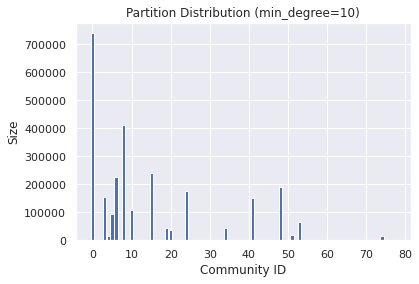

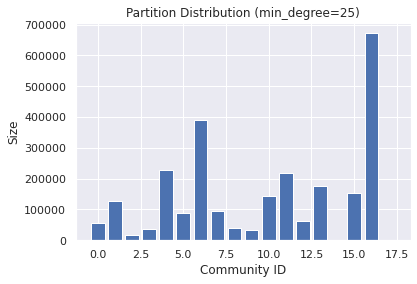

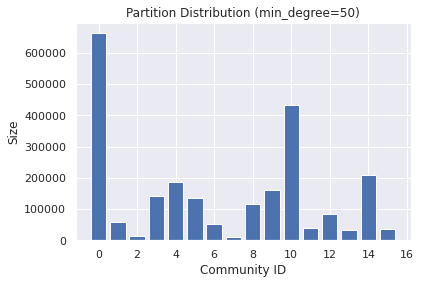

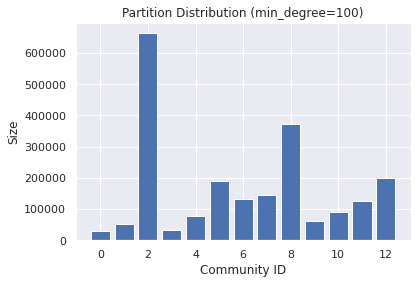

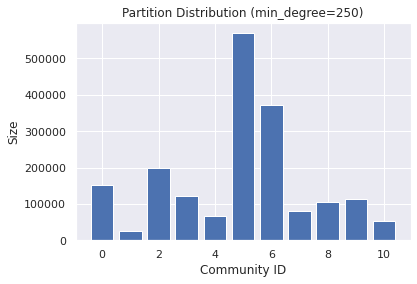

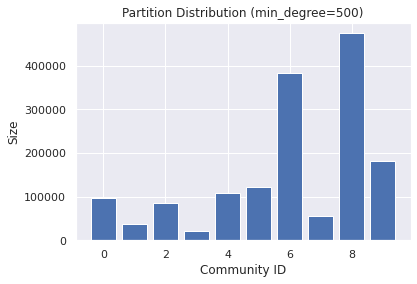

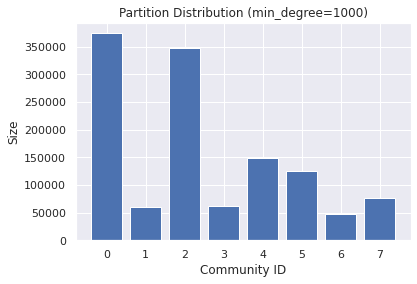

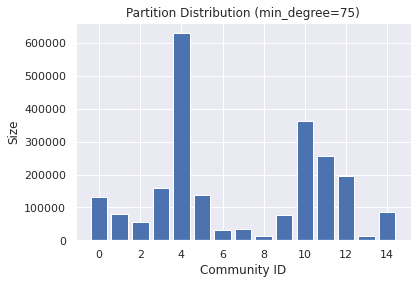

In [72]:
for degree, _ in community_mapping:
    bp_object, mapping = community_mapping[(degree,_)]
#     plot_partition_distribution2(mapping, degree)
    plot_partition_distribution_special(mapping, df, degree)

# Saving Generated Communities

Based off modularity, median community size, and # of communities, it looks like min_degree=250 is a good partition for us to use, since it also has one of the more even distributions

In [37]:
part50 = community_mapping[(50, 1.0)][1]
with open(os.path.join(os.getcwd(), 'saved_communities', 'part50.pickle'), 'wb') as f:
    pickle.dump(part50, f)

In [ ]:
with open(os.path.join(os.getcwd(), 'saved_communities', 'part75.pickle'), 'wb') as f:
    pickle.dump(part75, f)

In [47]:
part100 = community_mapping[(100, 1.0)][1]
with open(os.path.join(os.getcwd(), 'saved_communities', 'part100.pickle'), 'wb') as f:
    pickle.dump(part100, f)

In [70]:
part250 = community_mapping[(250, 1.0)][1]
with open(os.path.join(os.getcwd(), 'saved_communities', 'part100.pickle'), 'wb') as f:
    pickle.dump(part250, f)